# pySEAFOM Frequency Response

**Repository:** SEAFOM-Fiber-Optic-Monitoring-Group/pySEAFOM

This notebook runs the frequency response analysis in the **pySEAFOM** library using synthetic or real DAS data.

## Overview

This notebook:

- Loads a 2D DAS matrix `.npy`
- Extracts a 1D trace in a spatial window around `POS_M`
- Optionally converts phase (rad) → strain (µε) and applies a high‑pass filter
- Runs the MSP‑02 frequency response analysis:
  - Local diagnostics: **time trace**, **spectrogram**, and **FFT spectrum**.
  - Outputs: **DAS frequency response** and **Normalized frequency response**.

## Key outputs (per run)

- **Normalized Frequency Response** (frequency points vs dB)
- Optional plots (local diagnostics + response curves)
- Optional CSV:
  - `frequency_response_normalized.csv` (frequency points + normalized dB)



## 1. Setup and Imports

Import `pySEAFOM.frequency_response` and basic Python utilities.


In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt

from pySEAFOM import frequency_response


## 2. Configure the Test Parameters

Edit the constants below to match your data:

- **FOLDER_OR_FILE**: folder containing `.npy` files (or a single `.npy` file)
- **REPETITION_RATE_HZ**: sampling/interrogator rate (Hz)
- **DELTA_X_M**: spatial resolution (m)

Stretcher region:

- **STRETCHER_START_M / STRETCHER_END_M**: stretcher bounds (m)
- **SPAN_M**: averaging half-width around the stretcher center (m) applied on each side (±SPAN_M; total window = 2·SPAN_M)

Analysis settings:

- **N_STEPS**: number of frequency steps
- **FREQ_MIN_FRAC_NYQ / FREQ_MAX_FRAC_NYQ**: window as fractions of Nyquist
- **WINDOW_SPECTROGRAM_S / OVERLAP_SPECTROGRAM_FRAC**: spectrogram parameters


In [2]:
# ======================================================================
# CONTROL
# ======================================================================
SAVE_RESULTS = True                 # If True, saves figures + CSV files in OUTPUT_DIR
OUTPUT_DIR = "results_frequency_response"
SHOW_PLOTS = True                   # If True, displays figures (plt.show)
PLOT_METADATA_BOX = True            # If True, adds a measurement-parameter box to the plot


# ======================================================================
# INPUT PARAMETERS (data extraction)
# ======================================================================
FOLDER_OR_FILE = "."                # Folder with .npy files or a single .npy file
REPETITION_RATE_HZ = 10_000.0       # Sampling / interrogation rate [Hz]
DELTA_X_M = 1.0                     # Spatial step between channels [m]


# ======================================================================
# INPUT PARAMETERS (analysis)
# ======================================================================
DATA_IS_STRAIN = False              # True if loaded trace is already strain [µε]
GAUGE_LENGTH_M = 10.0               # Gauge length used by interrogator [m]
HIGHPASS_HZ = None                  # High-pass cutoff [Hz] (set None to disable)

STRETCHER_START_M = 20.0            # [m]
STRETCHER_END_M = 30.0              # [m]
SPAN_M = 5.0                       # Spatial averaging span (±SPAN_M) [m]

N_STEPS = 40                        # Number of points in window
FREQ_MIN_FRAC_NYQ = 0.02            #  min fraction of Nyquist
FREQ_MAX_FRAC_NYQ = 0.80            #  max fraction of Nyquist

WINDOW_SPECTROGRAM_S = 0.5          # [s] Spectrogram window length
OVERLAP_SPECTROGRAM_FRAC = 0.5      # [%] Percentage overlap between spectrogram windows (0.5 = 50%)

## 3. Load DAS Data and Extract a 1D Local Trace

`load_frequency_response_data(...)` reads the 2D matrix and returns:

- `time_s`: time vector (s)
- `trace_raw`: extracted local 1D trace (original units: phase or strain)
- `distance_m`: distance vector (m)
- `local_pos_m`: stretcher center position used for the local window (m)


In [3]:
time_s, trace_raw, distance_m, local_pos_m = frequency_response.load_frequency_response_data(
    folder_or_file=FOLDER_OR_FILE,
    fs=REPETITION_RATE_HZ,
    delta_x_m=DELTA_X_M,
    stretcher_start_m=STRETCHER_START_M,
    stretcher_end_m=STRETCHER_END_M,
    span_m=SPAN_M,
    matrix_layout="auto",
)

print(f"[INFO] Loaded: {os.path.abspath(FOLDER_OR_FILE)}")
print(f"[INFO] trace_raw.shape={trace_raw.shape} (time,)")
print(f"[INFO] time=[{time_s[0]:.3f},{time_s[-1]:.3f}] s | n_time={time_s.size} | fs={REPETITION_RATE_HZ}")
print(f"[INFO] dist=[{distance_m[0]:.1f},{distance_m[-1]:.1f}] m | n_space={distance_m.size} | dx={DELTA_X_M}")
print(f"[INFO] local_pos={local_pos_m:.2f} m | span=±{SPAN_M} m")
print(f"[INFO] matrix_layout={'auto'} | data_is_strain={DATA_IS_STRAIN}")


[INFO] Loaded: d:\Petrobras\pySEAFOM2
[INFO] trace_raw.shape=(1000001,) (time,)
[INFO] time=[0.000,100.000] s | n_time=1000001 | fs=10000.0
[INFO] dist=[0.0,49.0] m | n_space=50 | dx=1.0
[INFO] local_pos=25.00 m | span=±5.0 m
[INFO] matrix_layout=auto | data_is_strain=False


## 4. Spatio‑Temporal Map (µε) + Span Window

This optional plot shows a **time × distance** colormap (in µε) and highlights:

- The **stretcher bounds** (`STRETCHER_START_M` to `STRETCHER_END_M`)
- The **local averaging window** (`local_pos_m ± SPAN_M`) used to extract `trace_raw`

It is meant only to confirm that the chosen span matches your intent.


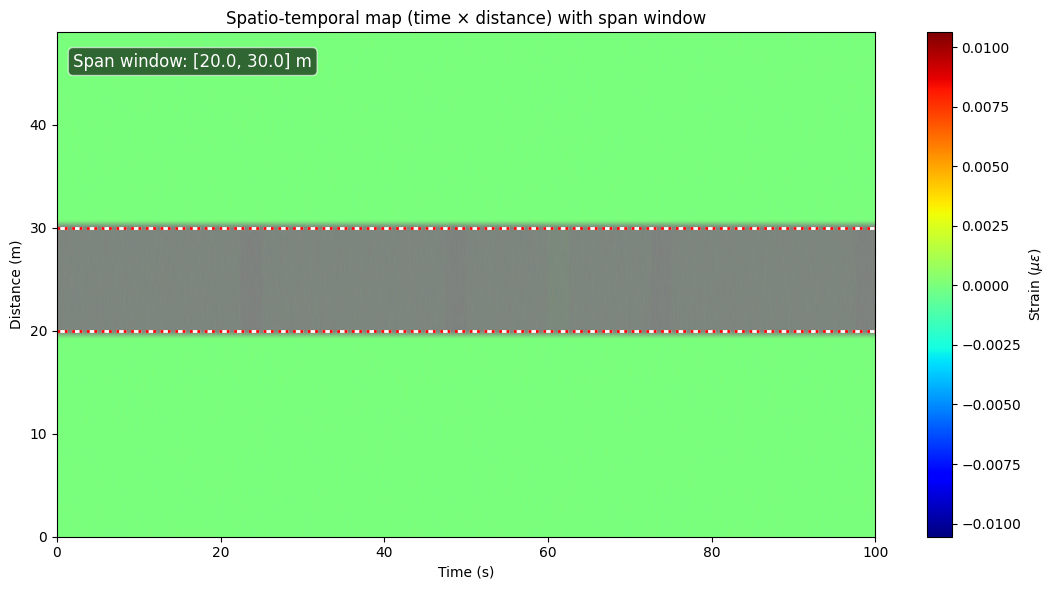

In [4]:
if SHOW_PLOTS:
    def _pick_first_npy(folder_or_file: str) -> str:
        p = os.path.expanduser(folder_or_file)
        if os.path.isdir(p):
            npys = sorted([f for f in os.listdir(p) if f.lower().endswith(".npy")])
            if not npys:
                raise FileNotFoundError(f"No .npy found in folder: {p!r}")
            return os.path.join(p, npys[0])
        if not p.lower().endswith(".npy"):
            raise ValueError(f"Expected a .npy file or folder, got: {folder_or_file!r}")
        if not os.path.exists(p):
            raise FileNotFoundError(f"NPY file not found: {p!r}")
        return p

    npy_path = _pick_first_npy(FOLDER_OR_FILE)
    mat = np.asarray(np.load(npy_path)).squeeze()
    if mat.ndim != 2:
        raise ValueError(f"Expected a 2D matrix in {npy_path!r}, got shape={mat.shape}.")

    if DATA_IS_STRAIN:
        data_ue_2d = mat.astype(float)
    else:
        data_ue_2d = frequency_response.phase_to_strain(
            mat.astype(float),
            gauge_length=float(GAUGE_LENGTH_M),
            output_in_microstrain=True,
        )

    extent = [time_s[0], time_s[-1], distance_m[0], distance_m[-1]]

    plt.figure(figsize=(11, 6))
    im = plt.imshow(
        data_ue_2d.T,
        extent=extent,
        aspect="auto",
        origin="lower",
        cmap="jet",
    )
    plt.colorbar(im, label=r"Strain ($\mu\varepsilon$)")
    plt.xlabel("Time (s)")
    plt.ylabel("Distance (m)")
    plt.title("Spatio-temporal map (time × distance) with span window")

    y1 = float(local_pos_m) - float(SPAN_M)
    y2 = float(local_pos_m) + float(SPAN_M)
    plt.axhline(y1, color="w", linestyle="--", linewidth=2.0)
    plt.axhline(y2, color="w", linestyle="--", linewidth=2.0)

    plt.axhline(float(STRETCHER_START_M), color="r", linestyle=":", linewidth=2.0)
    plt.axhline(float(STRETCHER_END_M), color="r", linestyle=":", linewidth=2.0)

    plt.text(
        0.02, 0.96,
        f"Span window: [{y1:.1f}, {y2:.1f}] m",
        transform=plt.gca().transAxes,
        ha="left", va="top",
        color="w",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="black", ec="white", alpha=0.6),
    )
    plt.tight_layout()
    plt.show()


## 5. Convert to Microstrain (and Optional High‑Pass)

If `DATA_IS_STRAIN=False`, the trace is interpreted as **phase** (rad) and converted to strain (µε)
using the same physics used by `pySEAFOM.dynamic_range.data_processing()`.


In [5]:
signal_ue = frequency_response.data_processing(
    trace=trace_raw,
    data_is_strain=DATA_IS_STRAIN,
    gauge_length=GAUGE_LENGTH_M,
    fs=REPETITION_RATE_HZ,
    highpass_hz=HIGHPASS_HZ,
)


## 6. Frequency Response Analysis

Run:

- Local diagnostics (time trace, spectrogram, FFT)
- DAS frequency response curve
- Normalized frequency response curve (window)

Optional outputs are controlled by:

- `SHOW_PLOTS`
- `SAVE_RESULTS`
- `OUTPUT_DIR`
- `PLOT_METADATA_BOX`


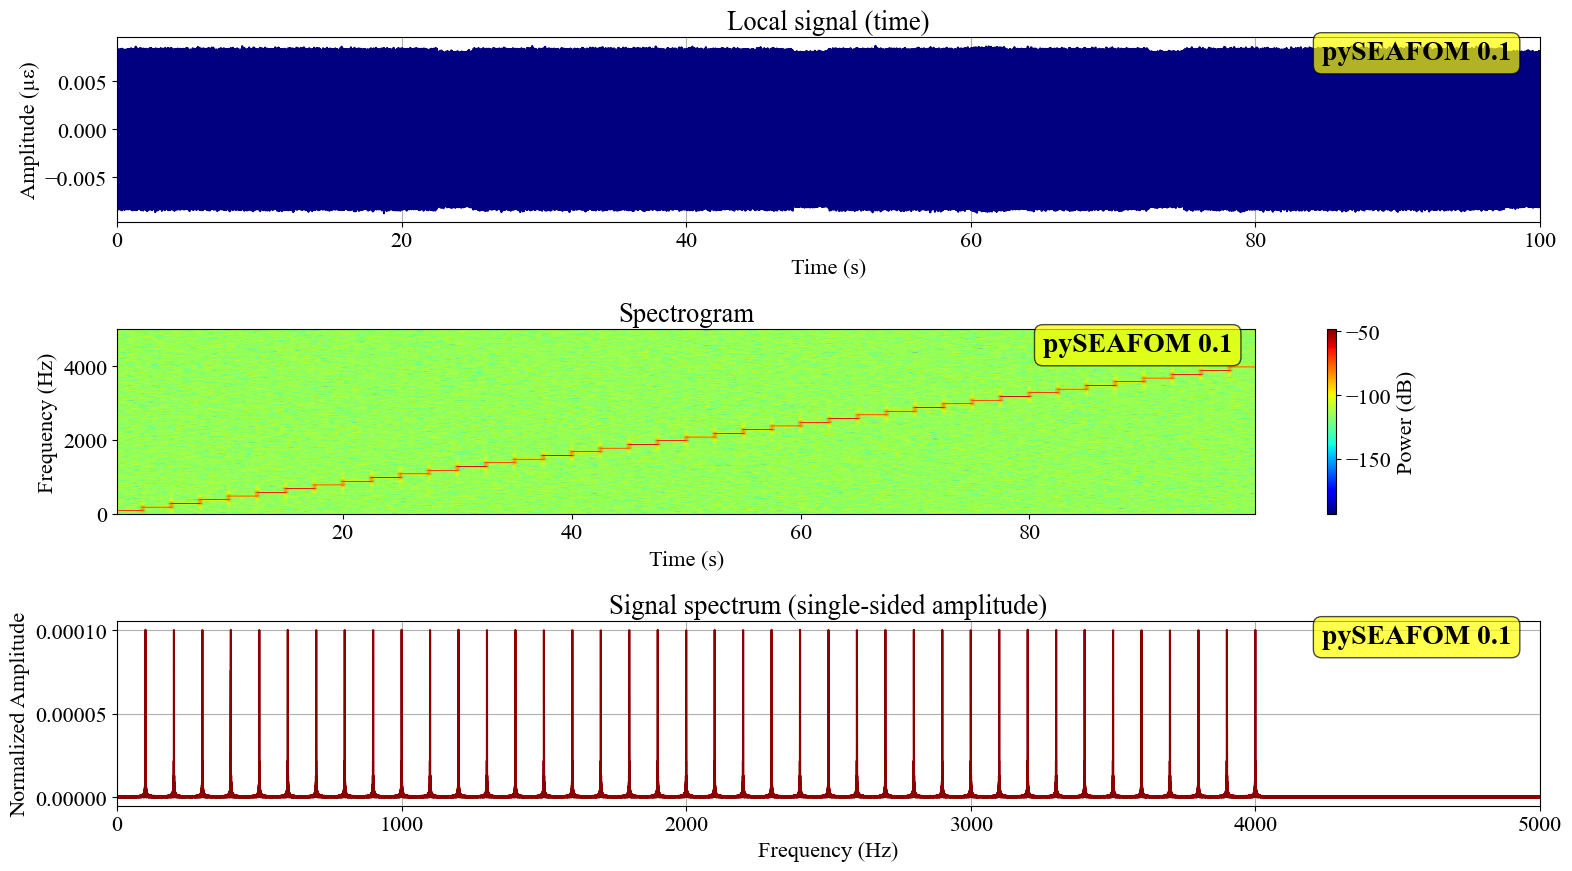

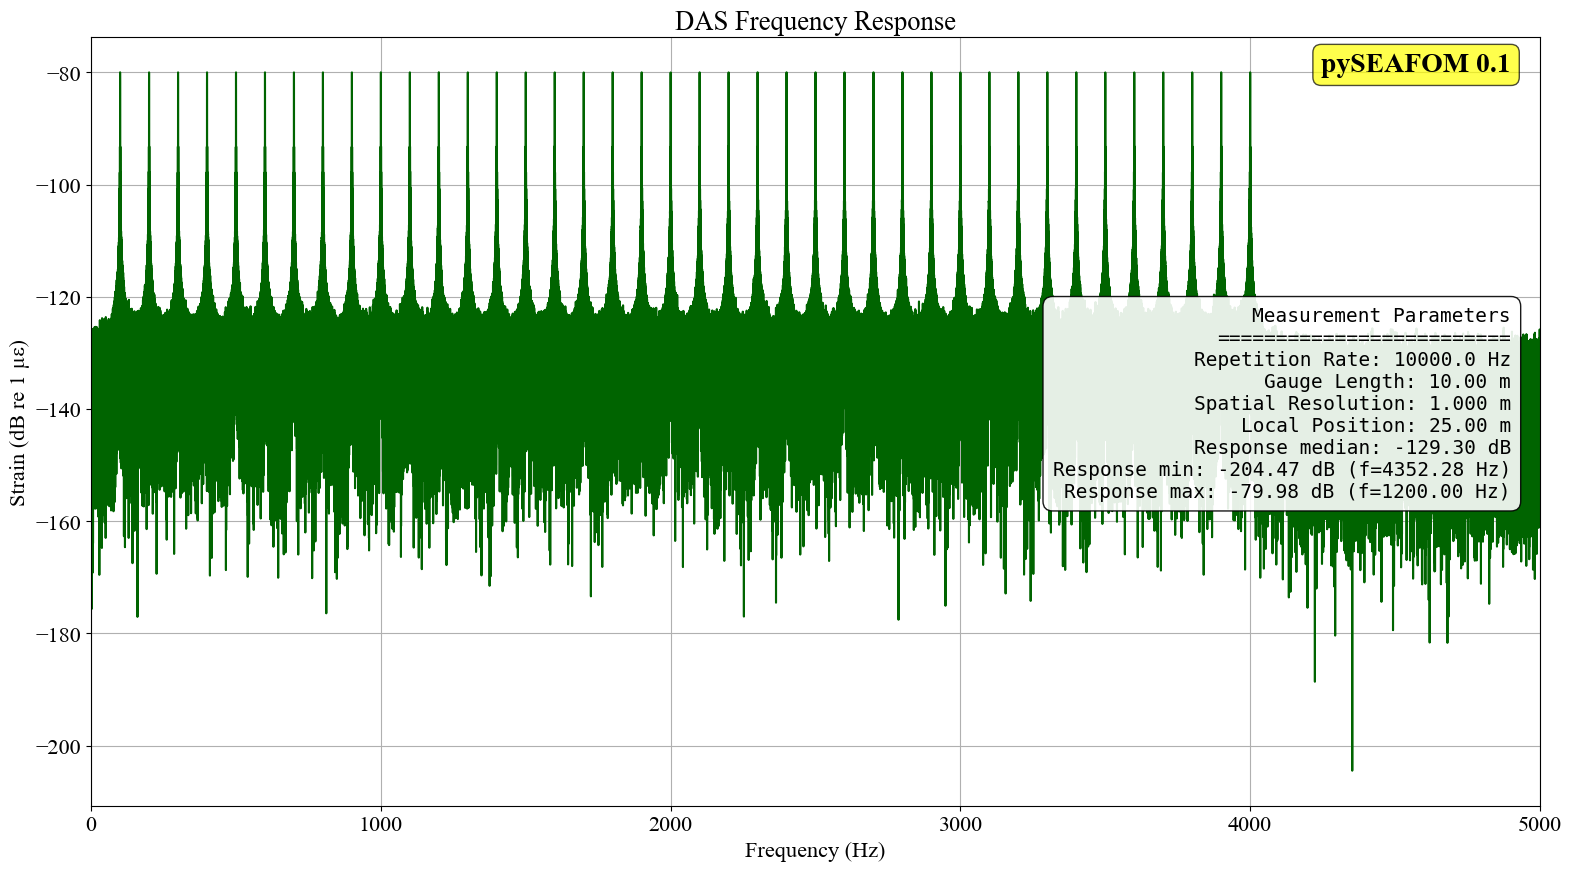

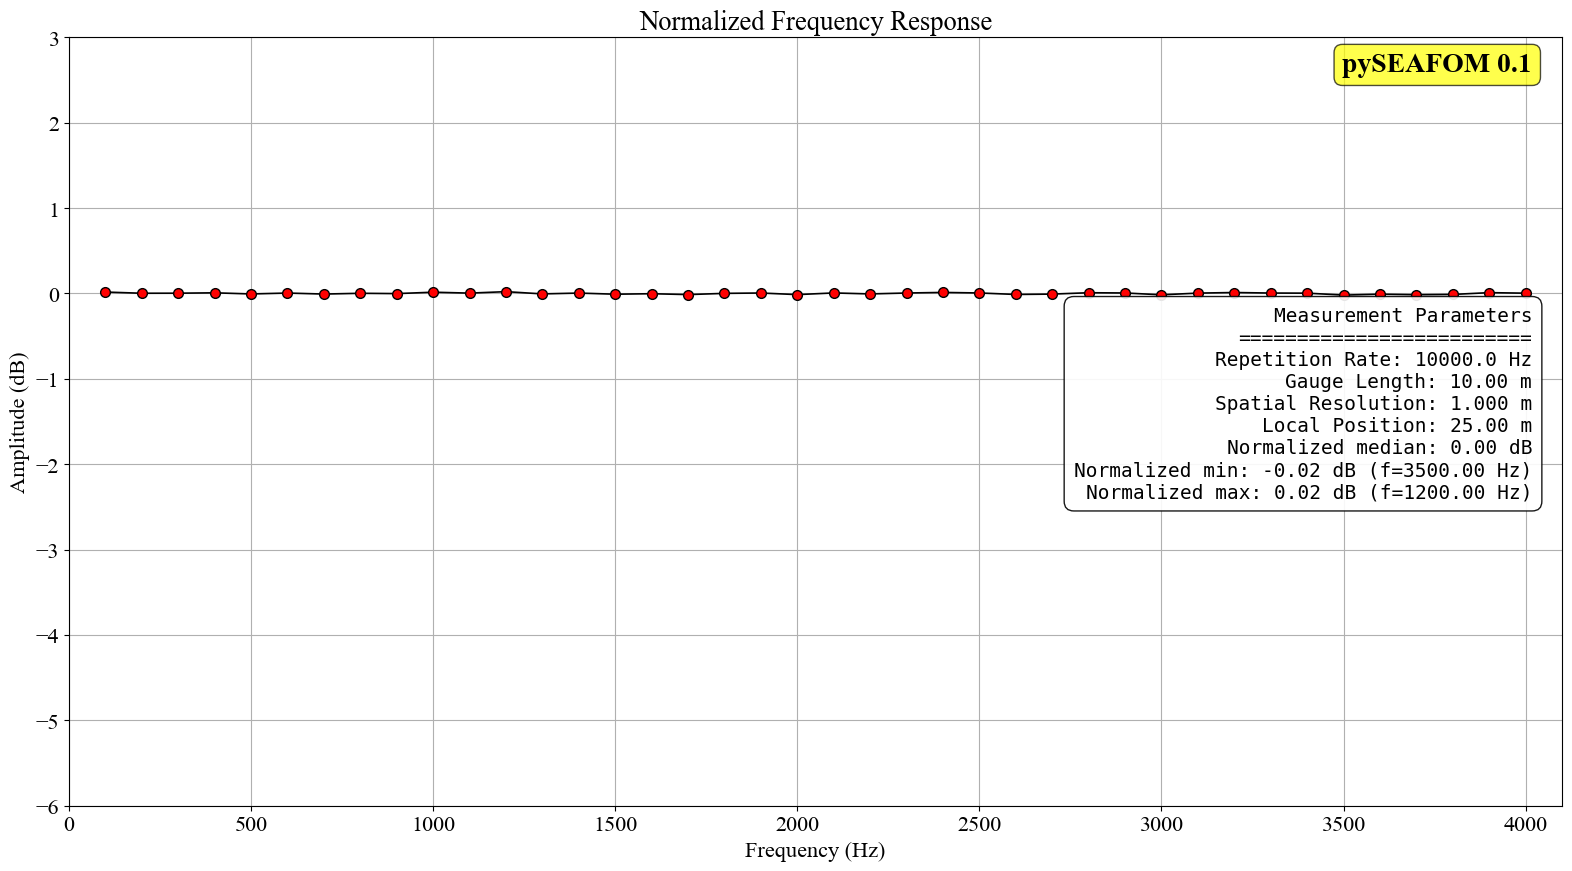


=== Frequency Response Analysis Completed ===
Central position: 25.00 m
Gauge length: 10.00 m
Interrogation rate: 10000.0 Hz
N steps: 40
Results dir: d:\Petrobras\pySEAFOM2\results_frequency_response
Returned dictionary keys: ['local_analysis_position_m', 'signal_microstrain', 'frequency_hz', 'amplitude_db_re_1ue', 'freq_points_hz', 'normalized_db', 'plot_response_path', 'plot_normalized_path', 'csv_normalized_path']


In [6]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

results = frequency_response.analyze_frequency_response(
    # 1) required data
    time_s=time_s,
    signal_microstrain=signal_ue,
    interrogation_rate_hz=REPETITION_RATE_HZ,

    # 2) optional analysis parameters
    n_steps=N_STEPS,
    freq_min_frac_nyq=FREQ_MIN_FRAC_NYQ,
    freq_max_frac_nyq=FREQ_MAX_FRAC_NYQ,
    window_spectrogram_s=WINDOW_SPECTROGRAM_S,
    overlap_spectrogram_frac=OVERLAP_SPECTROGRAM_FRAC,
    delta_x_m=DELTA_X_M,

    # 3) optional metadata / run context (plot box + CSV)
    local_analysis_position_m=local_pos_m,
    gauge_length=GAUGE_LENGTH_M,

    # 4) I/O options
    show_plot=SHOW_PLOTS,
    save_results=SAVE_RESULTS,
    results_dir=OUTPUT_DIR,
    plot_metadata_box=PLOT_METADATA_BOX,
)

print("\n=== Frequency Response Analysis Completed ===")
print(f"Central position: {local_pos_m:.2f} m")
print(f"Gauge length: {GAUGE_LENGTH_M:.2f} m")
print(f"Interrogation rate: {REPETITION_RATE_HZ:.1f} Hz")
print(f"N steps: {N_STEPS}")
print(f"Results dir: {os.path.abspath(OUTPUT_DIR)}")
print("Returned dictionary keys:", list(results.keys()))


## 7. Minimal Calls (Examples)

Examples in the last section show how to call the analysis with **defaults** and minimal parameters


In [7]:
# Minimal call (defaults from the library)
#frequency_response.analyze_frequency_response(
#    time_s=time_s,
#    signal_microstrain=signal_ue,
#    interrogation_rate_hz=REPETITION_RATE_HZ,
#)

# Minimal call + metadata box
#frequency_response.analyze_frequency_response(
#    time_s=time_s,
#   signal_microstrain=signal_ue,
#   interrogation_rate_hz=REPETITION_RATE_HZ,
#    plot_metadata_box=PLOT_METADATA_BOX,
#)


## 8. Output Artifacts

If `SAVE_RESULTS=True`, the following are written to `OUTPUT_DIR`:

* Local diagnostics plot(s)
* `frequency_response.png` and `frequency_response_normalized.png`
* `frequency_response_normalized.csv` (one row per frequency point)

CSV columns include:

* `frequency_hz` — frequency axis [Hz]
* `normalized_db` — normalized response [dB]
